In [1]:
import warnings
warnings.filterwarnings("ignore")
import copy
from pathlib import Path
import warnings

import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger
import numpy as np
import pandas as pd
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import MAE, SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import (
    optimize_hyperparameters,
)
import pandas as pd

In [2]:
receivals = pd.read_csv("../data_cleaned/orders_with_receivals_detailed.csv", parse_dates=['date_arrival', 'delivery_date'])
# Filter out rows with missing rm_id or date_arrival
receivals = receivals[receivals['rm_id'].notnull() & receivals['date_arrival'].notnull()]
# date_arrival = actual date of receival, delivery_date = expected date of receival
# lead_time = date_arrival - delivery_date
# quantity  = quantity, net_weight = weight in kg (the actual target per day etc)
selected = receivals[["rm_id", "date_arrival", "net_weight", "supplier_id", "delivery_date", "product_id_receival", "quantity", "lead_time"]]
# Filter out the selected rows where rm_id is null or date_arrival is null
selected = selected[selected['rm_id'].notnull() & selected['date_arrival'].notnull()]

In [3]:
# CREATING TIME_IDX AND AGGREGATING TO DAILY LEVEL AND FILLING GAPS WITH 0 NET_WEIGHT RECEIVALS


# make a copy and normalize date_arrival to date-only (drop time) so grouping is by year-month-day
df_agg = selected.copy()
# ensure date_arrival is a datetime and floor to day (sets time to 00:00:00)
df_agg['date_arrival'] = df_agg['date_arrival'].dt.floor('D')
# Remove timezone info if present
df_agg['date_arrival'] = df_agg['date_arrival'].dt.tz_localize(None)

df_agg = df_agg.groupby(['rm_id', 'date_arrival']).agg({
    'net_weight': 'sum',
    'quantity': 'sum',
}).reset_index()

# Add time_idx based on days since each rm_id's minimum date
df_agg = df_agg.sort_values(['rm_id', 'date_arrival'])
df_agg['local_time_idx'] = (df_agg['date_arrival'] - df_agg.groupby('rm_id')['date_arrival'].transform('min')).dt.days

# Fill gaps from each rm_id's min date to 2024-12-31 with 0 net_weight entries
end_date = pd.Timestamp('2024-12-31')
all_filled = []

for rm_id, group in df_agg.groupby('rm_id'):
    min_date = group['date_arrival'].min()
    max_idx = (end_date - min_date).days
    
    full_range = pd.DataFrame({
        'local_time_idx': range(0, max_idx + 1)
    })
    full_range['rm_id'] = rm_id
    full_range['date_arrival'] = min_date + pd.to_timedelta(full_range['local_time_idx'], unit='D')
    
    merged = pd.merge(full_range, group, on=['rm_id', 'local_time_idx', 'date_arrival'], how='left')
    merged['net_weight'] = merged['net_weight'].fillna(0)
    merged['quantity'] = merged['quantity'].fillna(0)
  
    all_filled.append(merged)

df_agg = pd.concat(all_filled, ignore_index=True)
selected_with_local_time = df_agg

In [4]:
print(selected_with_local_time.where(selected_with_local_time["rm_id"]==2130).dropna()[["local_time_idx", "date_arrival", "net_weight"]].tail(2))

        local_time_idx date_arrival  net_weight
488659          4794.0   2024-12-30         0.0
488660          4795.0   2024-12-31         0.0


In [5]:
# Add additional features
selected_with_local_time["month"] = selected_with_local_time["date_arrival"].dt.month.astype(str).astype("category")
selected_with_local_time["year"] = selected_with_local_time["date_arrival"].dt.year.astype(str).astype("category")
selected_with_local_time["day_of_week"] = selected_with_local_time["date_arrival"].dt.dayofweek.astype(str).astype("category")  # 0=Monday, 6=Sunday
selected_with_local_time["log_weight"] = np.log1p(selected_with_local_time["net_weight"])

# Norwegian special days/holidays
# Fixed holidays
def get_norwegian_holidays(year):
    """Return dictionary of Norwegian holidays for a given year"""
    from datetime import timedelta
    
    holidays = {}
    
    # Fixed date holidays
    holidays[f'{year}-01-01'] = 'New Year'
    holidays[f'{year}-05-01'] = 'Labour Day'
    holidays[f'{year}-05-17'] = 'Constitution Day'
    holidays[f'{year}-12-24'] = 'Christmas Eve'
    holidays[f'{year}-12-25'] = 'Christmas Day'
    holidays[f'{year}-12-26'] = 'Boxing Day'
    holidays[f'{year}-12-31'] = 'New Year Eve'
    
    # Easter-based holidays (Easter dates vary each year)
    # Approximate Easter calculation (Meeus/Jones/Butcher algorithm)
    a = year % 19
    b = year // 100
    c = year % 100
    d = b // 4
    e = b % 4
    f = (b + 8) // 25
    g = (b - f + 1) // 3
    h = (19 * a + b - d - g + 15) % 30
    i = c // 4
    k = c % 4
    l = (32 + 2 * e + 2 * i - h - k) % 7
    m = (a + 11 * h + 22 * l) // 451
    month = (h + l - 7 * m + 114) // 31
    day = ((h + l - 7 * m + 114) % 31) + 1
    
    easter = pd.Timestamp(year=year, month=month, day=day)
    
    # Easter-related holidays
    holidays[(easter - timedelta(days=3)).strftime('%Y-%m-%d')] = 'Maundy Thursday'
    holidays[(easter - timedelta(days=2)).strftime('%Y-%m-%d')] = 'Good Friday'
    holidays[easter.strftime('%Y-%m-%d')] = 'Easter Sunday'
    holidays[(easter + timedelta(days=1)).strftime('%Y-%m-%d')] = 'Easter Monday'
    holidays[(easter + timedelta(days=39)).strftime('%Y-%m-%d')] = 'Ascension Day'
    holidays[(easter + timedelta(days=49)).strftime('%Y-%m-%d')] = 'Whit Sunday'
    holidays[(easter + timedelta(days=50)).strftime('%Y-%m-%d')] = 'Whit Monday'
    
    return holidays

# Create a mapping of all dates to holidays
all_holidays = {}
for year in range(selected_with_local_time['date_arrival'].dt.year.min(), 
                  selected_with_local_time['date_arrival'].dt.year.max() + 1):
    all_holidays.update(get_norwegian_holidays(year))

# Add special day column
selected_with_local_time['date_str'] = selected_with_local_time['date_arrival'].dt.strftime('%Y-%m-%d')
selected_with_local_time['special_days'] = selected_with_local_time['date_str'].map(all_holidays).fillna('none').astype('category')
selected_with_local_time.drop('date_str', axis=1, inplace=True)

# Add binary flag for whether it's a holiday
selected_with_local_time['is_holiday'] = (selected_with_local_time['special_days'] != 'none').astype(int)

In [6]:
print(selected_with_local_time.where(selected_with_local_time["rm_id"]==2130).dropna().tail(2))


        local_time_idx   rm_id date_arrival  net_weight  quantity month  year  \
488659          4794.0  2130.0   2024-12-30         0.0       0.0    12  2024   
488660          4795.0  2130.0   2024-12-31         0.0       0.0    12  2024   

       day_of_week  log_weight  special_days  is_holiday  
488659           0         0.0          none         0.0  
488660           1         0.0  New Year Eve         1.0  


In [7]:
special_days = list(all_holidays.values())

# Make rm_id a string instead of numeric
selected_with_local_time["rm_id"] = selected_with_local_time["rm_id"].astype(int).astype(str).astype("category")
selected_with_local_time["is_holiday"] = selected_with_local_time["is_holiday"].astype(str).astype("category")
selected_with_local_time.drop("year", axis=1, inplace=True)
print(selected_with_local_time.head(0))

Empty DataFrame
Columns: [local_time_idx, rm_id, date_arrival, net_weight, quantity, month, day_of_week, log_weight, special_days, is_holiday]
Index: []


In [8]:
full_data = selected_with_local_time.copy()

def add_cutoff_per_group(df, group_col, max_pred_len):
    local_cutoffs = (
        df.groupby(group_col)["local_time_idx"].transform("max") - max_pred_len
    )
    df["is_val"] = df["local_time_idx"] > local_cutoffs
    return df

max_prediction_length = 151
max_encoder_length = 365
full_data = add_cutoff_per_group(full_data, "rm_id", max_prediction_length)

validation_set = full_data[full_data["is_val"]].copy()
validation_set = validation_set.drop("is_val", axis=1)
training_set = full_data[~full_data["is_val"]].copy()
training_set = training_set.drop("is_val", axis=1)

too_small_data_rm_ids = []  # rm ids in full_data that have less than max_encoder_length + max_prediction_length entries in training set[]
for rm_id, group in training_set.groupby("rm_id"):
    if len(group) <max_prediction_length+1:
        too_small_data_rm_ids.append(rm_id)

print(too_small_data_rm_ids)

training_set = training_set[~training_set["rm_id"].isin(too_small_data_rm_ids)].copy()
validation_set = validation_set[~validation_set["rm_id"].isin(too_small_data_rm_ids)].copy()

print(training_set[training_set["rm_id"]=="2130"].tail(2))

print(validation_set[validation_set["rm_id"]=="2130"].shape)
print(training_set[training_set["rm_id"]=="2130"].shape)


full_data = pd.concat([training_set, validation_set], ignore_index=True)


['3461', '4161', '4222', '4263', '4302', '4343', '4381', '4401', '4441', '4443', '4461', '4462', '4463', '4481', '4501']
        local_time_idx rm_id date_arrival  net_weight   quantity month  \
488508            4643  2130   2024-08-01    110021.0  5600000.0     8   
488509            4644  2130   2024-08-02    119544.0  6210000.0     8   

       day_of_week  log_weight special_days is_holiday  
488508           3   11.608436         none          0  
488509           4   11.691448         none          0  
(151, 10)
(4645, 10)


In [9]:
training = TimeSeriesDataSet(
    data = training_set,
    time_idx="local_time_idx",
    target="net_weight",
    group_ids=["rm_id"],
    min_encoder_length=max_encoder_length
    // 2,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=["rm_id"],
    #static_reals= no static real yet,
    time_varying_known_categoricals=["special_days", "month", "day_of_week", "is_holiday"],
    #variable_groups={
    #    "special_days": special_days
    #},  # group of categorical variables can be treated as one variable
    time_varying_known_reals=["local_time_idx"],
    # CAN PUT YEAR IN TIME_VARYING_KNOWN_REALS
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=[
        "quantity",
        "net_weight",
        "log_weight",
    ],
    target_normalizer=GroupNormalizer(
        groups=["rm_id"], transformation="softplus"
    ),  # use softplus and normalize by group
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)

# create validation set (predict=True) which means to predict the last max_prediction_length points in time
# for each series
validation = TimeSeriesDataSet.from_dataset(
    training, data=full_data, predict=True, stop_randomization=True
)

# create dataloaders for model
batch_size = 128  # set this between 32 to 128
train_dataloader = training.to_dataloader(
    train=True, batch_size=batch_size, num_workers=0
)
val_dataloader = validation.to_dataloader(
    train=False, batch_size=batch_size * 10, num_workers=0
)

In [10]:
# TRAINING THE MODEL
early_stop_callback = EarlyStopping(
    monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min"
)
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

# configure network and trainer
pl.seed_everything(42)
trainer = pl.Trainer(
    max_epochs=50,
    accelerator="gpu",
    enable_model_summary=True,
    gradient_clip_val=0.1,
    limit_train_batches=30,
    #fast_dev_run = True,
    callbacks=[lr_logger],
    logger=logger,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=0.01,
    hidden_size=8,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=1,
    dropout=0.1,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=8,  # set to <= hidden_size
    loss=QuantileLoss(),
    log_interval=10,
    optimizer="ranger",  # OPTIMIZER FOR FINDING BEST LEARNING RATE
    # reduce learning rate if no improvement in validation loss after x epochs
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size() / 1e3:.1f}k")

Seed set to 42
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Number of parameters in network: 10.4k


In [11]:
# fit network
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

You are using a CUDA device ('NVIDIA GeForce RTX 3070') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 1.7 K  | train
3  | prescalers                         | ModuleDict                      | 128    | train
4  | static_variable_selection          |

Epoch 49: 100%|██████████| 30/30 [00:13<00:00,  2.26it/s, v_num=37, train_loss_step=1.47e+3, val_loss=843.0, train_loss_epoch=1.23e+3]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 30/30 [00:13<00:00,  2.25it/s, v_num=37, train_loss_step=1.47e+3, val_loss=843.0, train_loss_epoch=1.23e+3]


Finding best initial lr: 100%|██████████| 100/100 [00:52<00:00,  1.90it/s]
Restoring states from the checkpoint path at c:\Users\david\OneDrive\Skrivebord\ML append project\append_consulting_project\testing\.lr_find_f2f9541a-303e-4730-99f5-d1afe9ca9f85.ckpt
Restored all states from the checkpoint at c:\Users\david\OneDrive\Skrivebord\ML append project\append_consulting_project\testing\.lr_find_f2f9541a-303e-4730-99f5-d1afe9ca9f85.ckpt
Learning rate set to 6.918309709189363e-06


suggested learning rate: 6.918309709189363e-06


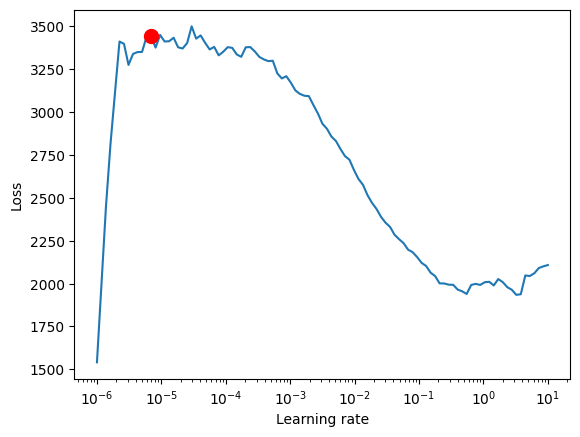

In [ ]:
# # YOU SHOULD DO THIS CAUSE THE OPTIMAL
# # LEARNING RATE PYTORCH LIGHTNING COULD
# # SOMETIMES BE CONFUSED BY THE NOISE AT LOWER LEARNING RATES
# # AND SUGGESTS RATES FAR TOO LOW. MANUAL CONTROL IS ESSENTIAL
# # # find optimal learning rate
# from lightning.pytorch.tuner import Tuner

# res = Tuner(trainer).lr_find(
#      tft,
#      train_dataloaders=train_dataloader,
#      val_dataloaders=val_dataloader,                                        
#      max_lr=10.0,
#      min_lr=1e-6,
#  )

# print(f"suggested learning rate: {res.suggestion()}")
# fig = res.plot(show=True, suggest=True)
# fig.show()

In [ ]:
# # HYPERPARAMETER TUNING WITH OPTUNA

# import pickle

# import optuna
# import optuna_integration
# import statsmodels
# from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

# # create study
# study = optimize_hyperparameters(
#     train_dataloader,
#     val_dataloader,
#     model_path="optuna_test",
#     n_trials=200,
#     max_epochs=50,
#     gradient_clip_val_range=(0.01, 1.0),
#     hidden_size_range=(8, 128),
#     hidden_continuous_size_range=(8, 128),
#     attention_head_size_range=(1, 4),
#     learning_rate_range=(0.001, 0.1),
#     dropout_range=(0.1, 0.3),
#     trainer_kwargs=dict(limit_train_batches=30),
#     reduce_on_plateau_patience=4,
#     use_learning_rate_finder=False,  # use Optuna to find ideal learning rate or use in-built learning rate finder
# )

# # save study results - also we can resume tuning at a later point in time
# with open("test_study.pkl", "wb") as fout:
#     pickle.dump(study, fout)

# # show best hyperparameters
# print(study.best_trial.params)

[I 2025-10-18 23:33:28,017] A new study created in memory with name: no-name-871a9b97-0525-423d-9c78-a0cb3868d127
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=50` reached.
[I 2025-10-18 23:56:24,794] Trial 0 finished with value: 561.6035766601562 and parameters: {'gradient_clip_val': 0.05550251786786674, 'hidden_size': 11, 'dropout': 0.2352490848087136, 'hidden_continuous_size': 11, 'attention_head_size': 1, 'learning_rate': 0.03338777348411531}. Best is trial 0 with value: 561.6035766601562.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=50` reached.
[I 2025-10-19 00:48:38,416] Trial 1 finished with value: 500.4615478515625 and parameters: {'gradient_clip_val': 0.4183264961564628, 'hidden_size': 28, 'dropout': 0.2890662323894735, 'hidden_continuous_size': 15, 'attention_head_size': 1, 'le

{'gradient_clip_val': 0.012179320703577733, 'hidden_size': 29, 'dropout': 0.12469376786070158, 'hidden_continuous_size': 14, 'attention_head_size': 1, 'learning_rate': 0.004342145465626561}


In [12]:
################# FULLL PREDICTION FOR ALL RM_IDs ###############


rm_ids = full_data['rm_id'].unique().tolist()
predict_data = []
# Create prediction date range
pred_start = pd.Timestamp('2025-01-01')
pred_end = pd.Timestamp('2025-05-31')
pred_dates = pd.date_range(start=pred_start, end=pred_end, freq='D')

all_predict_dfs = []

for rm_id in rm_ids:
    test_rm_id = rm_id  # must match categorical rm_id type
    historical = full_data[full_data['rm_id'] == test_rm_id].copy()
    if historical.empty:
        continue
    min_date = historical['date_arrival'].min()

    # build prediction rows for this rm_id
    rows = []
    for date in pred_dates:
        time_idx = (date - min_date).days
        date_str = date.strftime('%Y-%m-%d')
        special_day = all_holidays.get(date_str, 'none')
        is_holiday = '1' if special_day != 'none' else '0'

        rows.append({
            'rm_id': test_rm_id,
            'date_arrival': date,
            'local_time_idx': time_idx,
            'month': str(date.month),
            'day_of_week': str(date.dayofweek),
            'special_days': special_day,
            'is_holiday': is_holiday,
            'net_weight': 0,   # placeholder
            'quantity': 0,     # placeholder
            'log_weight': 0    # placeholder
        })

    pred_df_rm = pd.DataFrame(rows)

    # encoder/context data (last max_encoder_length days)
    encoder_data = historical.tail(max_encoder_length).copy()
    encoder_data['local_time_idx'] = encoder_data['local_time_idx'].astype(int)

    # combine encoder + prediction for this rm_id and collect
    combined = pd.concat([encoder_data, pred_df_rm], ignore_index=True)
    all_predict_dfs.append(combined)

# final combined prediction dataframe for all rm_ids
predict_data = pd.concat(all_predict_dfs, ignore_index=True)

predict_data = pd.DataFrame(predict_data)

# Convert to categorical to match training data
predict_data['rm_id'] = predict_data['rm_id'].astype(str).astype('category')
predict_data['month'] = predict_data['month'].astype(str).astype('category')
predict_data['day_of_week'] = predict_data['day_of_week'].astype(str).astype('category')
predict_data['special_days'] = predict_data['special_days'].astype(str).astype('category')
predict_data['is_holiday'] = predict_data['is_holiday'].astype(str).astype('category')

# Ensure local_time_idx is integer (required by TimeSeriesDataSet)
predict_data['local_time_idx'] = predict_data['local_time_idx'].astype(int)

print(f"Prediction dataframe shape: {predict_data.shape}")
print(f"Date range: {predict_data['date_arrival'].min()} to {predict_data['date_arrival'].max()}")
print(f"Time index range: {predict_data['local_time_idx'].min()} to {predict_data['local_time_idx'].max()}")
print("\nFirst few rows:")
print(predict_data.head())

Prediction dataframe shape: (97008, 10)
Date range: 2024-01-02 00:00:00 to 2025-05-31 00:00:00
Time index range: 14 to 7655

First few rows:
   local_time_idx rm_id date_arrival  net_weight  quantity month day_of_week  \
0            7132   342   2024-01-02         0.0       0.0     1           1   
1            7133   342   2024-01-03         0.0       0.0     1           2   
2            7134   342   2024-01-04         0.0       0.0     1           3   
3            7135   342   2024-01-05         0.0       0.0     1           4   
4            7136   342   2024-01-06         0.0       0.0     1           5   

   log_weight special_days is_holiday  
0         0.0         none          0  
1         0.0         none          0  
2         0.0         none          0  
3         0.0         none          0  
4         0.0         none          0  


In [13]:
predictions = tft.predict(predict_data, return_x=True, return_index=True, return_decoder_lengths=True)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [14]:
ltdx_and_rmid = predictions.index

output = predictions.output

In [16]:
pred = []

pred_start = pd.Timestamp('2025-01-01')
pred_end = pd.Timestamp('2025-05-31')
pred_dates = pd.date_range(start=pred_start, end=pred_end, freq='D')


for rm_id_index in range(0,188):
    rm_id_test = ltdx_and_rmid["rm_id"][rm_id_index]
    ltdx_test = ltdx_and_rmid["local_time_idx"][rm_id_index]
    for date in pred_dates:
        pred_weight = output[rm_id_index][(date-pred_start).days].item()
        pred.append({
            "rm_id": rm_id_test,
            "local_time_idx": ltdx_test,
            "date": date,
            "predicted_weight": pred_weight
        })

In [17]:
pred = pd.DataFrame(pred)
pred_over_0 = pred[pred["predicted_weight"]>0]
print(pred_over_0.head(0))

Empty DataFrame
Columns: [rm_id, local_time_idx, date, predicted_weight]
Index: []


In [18]:
sample_submission = pd.read_csv("../data/sample_submission.csv")
prediction_mapping = pd.read_csv("../data/prediction_mapping.csv")

submission = sample_submission.merge(prediction_mapping, on="ID")
submission["forecast_end_date"] = pd.to_datetime(submission["forecast_end_date"])
submission["forecast_start_date"] = pd.to_datetime(submission["forecast_start_date"])

In [19]:
for p in pred_over_0.itertuples():
    rm_id = p.rm_id
    date_arrival = p.date.replace(tzinfo=None)
    predicted_weight = p.predicted_weight
    submission.loc[
        (submission['rm_id'] == int(rm_id)) & (submission['forecast_end_date'] >= date_arrival),
        'predicted_weight'
    ] += predicted_weight*0.8  # applying a scaling factor of 0.8 to predictions

In [20]:
print(submission[submission["predicted_weight"]>0])

          ID  predicted_weight  rm_id forecast_start_date forecast_end_date
2550    2551      3.467479e-25    383          2025-01-01        2025-01-02
2551    2552      3.778459e-24    383          2025-01-01        2025-01-03
2552    2553      3.822672e-24    383          2025-01-01        2025-01-04
2553    2554      4.096434e-24    383          2025-01-01        2025-01-05
2554    2555      8.011477e-24    383          2025-01-01        2025-01-06
...      ...               ...    ...                 ...               ...
27145  27146      4.378310e+02   3901          2025-01-01        2025-05-27
27146  27147      4.378310e+02   3901          2025-01-01        2025-05-28
27147  27148      4.378310e+02   3901          2025-01-01        2025-05-29
27148  27149      4.378310e+02   3901          2025-01-01        2025-05-30
27149  27150      4.378310e+02   3901          2025-01-01        2025-05-31

[5034 rows x 5 columns]


In [21]:
print(pred_over_0)

      rm_id  local_time_idx       date  predicted_weight
2416   1872            6036 2025-01-01      1.652519e-22
2417   1872            6036 2025-01-02      4.705574e-23
2418   1872            6036 2025-01-03      2.977136e-22
2419   1872            6036 2025-01-04      5.388077e-23
2420   1872            6036 2025-01-05      1.059205e-22
...     ...             ...        ...               ...
27405  3901             520 2025-03-16      1.140577e+01
27410  3901             520 2025-03-21      1.252668e+02
27412  3901             520 2025-03-23      3.352637e+01
27417  3901             520 2025-03-28      1.513601e+02
27419  3901             520 2025-03-30      5.484912e+01

[3638 rows x 4 columns]


In [22]:
print(submission)

          ID  predicted_weight  rm_id forecast_start_date forecast_end_date
0          1               0.0    365          2025-01-01        2025-01-02
1          2               0.0    365          2025-01-01        2025-01-03
2          3               0.0    365          2025-01-01        2025-01-04
3          4               0.0    365          2025-01-01        2025-01-05
4          5               0.0    365          2025-01-01        2025-01-06
...      ...               ...    ...                 ...               ...
30445  30446               0.0   4501          2025-01-01        2025-05-27
30446  30447               0.0   4501          2025-01-01        2025-05-28
30447  30448               0.0   4501          2025-01-01        2025-05-29
30448  30449               0.0   4501          2025-01-01        2025-05-30
30449  30450               0.0   4501          2025-01-01        2025-05-31

[30450 rows x 5 columns]


In [23]:
filtered = submission.copy()

agg_df = filtered.groupby("rm_id", as_index=False).agg({
    "predicted_weight": "max",
}).sort_values("predicted_weight", ascending=False)

In [25]:
print(agg_df[agg_df["predicted_weight"]>0])

     rm_id  predicted_weight
75    2130      3.637294e+06
176   3781      3.123420e+06
180   3865      2.554863e+06
151   3126      1.724767e+06
102   2160      1.033341e+06
160   3282      5.243461e+05
147   3122      5.134964e+05
150   3125      4.649506e+05
83    2140      2.763027e+05
148   3123      1.939115e+05
149   3124      1.179385e+05
164   3441      6.128073e+04
85    2142      1.500448e+04
79    2134      1.378100e+03
80    2135      7.289326e+02
77    2132      7.085543e+02
182   3901      4.378310e+02
159   3265      5.977037e+01
104   2182      3.958438e+01
76    2131      2.751895e+01
27     387      1.305760e-18
47    1872      1.313811e-19
25     383      5.474200e-21
67    2121      2.086539e-21
30     390      3.535654e-22
120   2345      1.102391e-24
11     360      3.902103e-25
68    2122      1.506396e-26
134   2561      1.481535e-28
111   2284      5.901970e-29
48    1873      1.309772e-31
10     358      3.460416e-33
49    1874      1.828491e-37
103   2161    

In [26]:
submission_final = submission[["ID", "predicted_weight"]]
submission_final.to_csv("deadHYP.csv", index=False)

In [29]:
raw_predictions = tft.predict(
    val_dataloader, mode="raw", return_x=True, trainer_kwargs=dict(accelerator="cpu")
)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


{'attention': <Figure size 640x480 with 1 Axes>,
 'static_variables': <Figure size 700x300 with 1 Axes>,
 'encoder_variables': <Figure size 700x425 with 1 Axes>,
 'decoder_variables': <Figure size 700x350 with 1 Axes>}

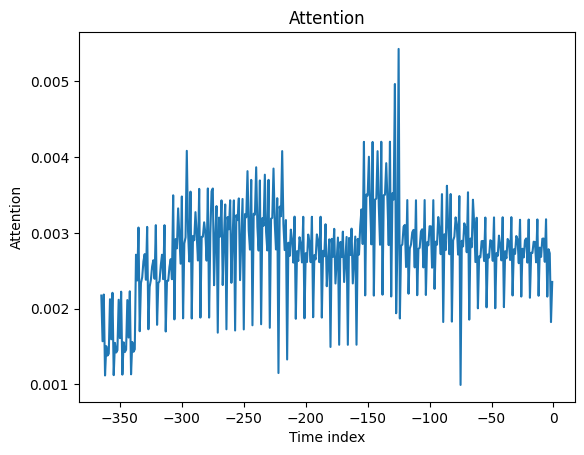

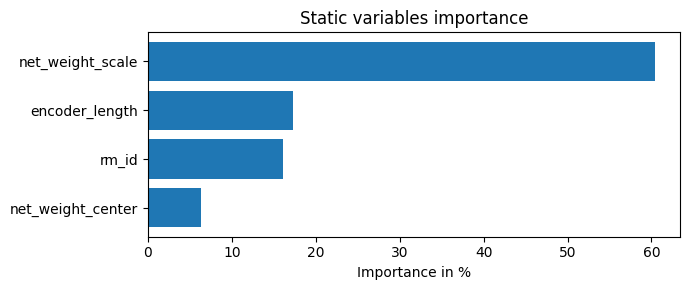

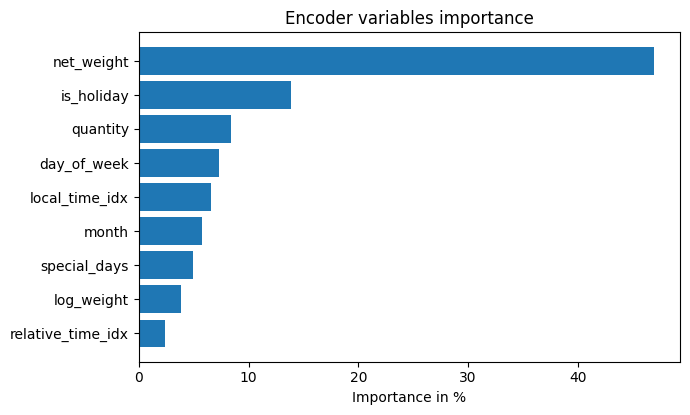

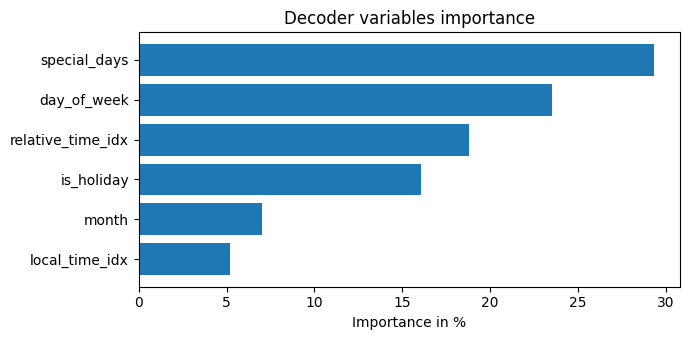

In [30]:
interpretation = tft.interpret_output(raw_predictions.output, reduction="sum")
tft.plot_interpretation(interpretation)